# EPA112A - Programming for Data Science - Group 31

- Georges Puttaert - 4686160
- Thijs Roolvink - 4961382
- Gijs de Werd - 4717775

## Introduction

The Gross Domestic Product (GDP) of a country is a fundamental measure of its economic well-being and prosperity. Understanding the factors that influence GDP is of importance for governments, policymakers, and economists. In our research project, we analyse some of these critical drivers by comparing the economies and their GDP over the years of the Netherlands, Germany, Greece, and Ireland.

In our research project, we analyse some of these critical drivers by comparing the economies and their GDP over the years of the Netherlands, Germany, Greece, and Ireland.
These four countries have been selected for their distinct economic sizes and profiles, making them ideal candidates for our analysis. The Netherlands and Germany represent two of the largest and most robust economies in Europe, while Greece and Ireland, while smaller in scale, offer insights into the economic characteristics of Southern and Western Europe. By analyzing a diverse set of economies, we aim to draw valuable insights into the factors that shape GDP.

Our analyses focuses on three categories of indicators: Social, Economic (Governance), and Environmental. Each category includes a set of indicators that may have a significant influence on a country's GDP.

## Research Question

 **How significantly do ESG (Environmental, Social, and Governance) indicators impact a country's GDP? Among Random Forest, Linear Regression, and MLP, which machine learning model offers the most accurate GDP predictions based on these indicators?**


 ## Sub questions
 - How do ESG correlate with GDP per capita?
 - Which machine learning model has the greatest errors?
 - Are there signifact differences regarding several performance metric for each countries per machine learning model?

*Chosen Countries per category:*
- The Netherlands 
- Germany
- Greece
- Ireland

### Packages

In [1]:
import wbdata
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import country_converter as coco
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import math
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error


warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode()

### Indicators from the World Bank

In [2]:
# Define indicators Inequality and Social Welfare
health_indicators = {'SH.XPD.CHEX.GD.ZS': "Health Expenditure as a Percentage of GDP", "SH.IMM.IDPT": "Immunization"}
GDP_indicator = {'NY.GDP.PCAP.CD': 'gdppc'}
life_exp_indicator = {'SP.DYN.LE00.IN': 'Life Expectancy at Birth', 'SH.DYN.MORT': 'Child Mortality'}
disease_indicator = {'SH.TBS.INCD': 'Indicence of Diseases'} 

#Define indicators Import & Export
export_indicator = {'NE.EXP.GNFS.KD.ZG': 'Export'}
import_indicator = {'NE.IMP.GNFS.KD.ZG': 'Import'}
freight_indicator = {'IS.AIR.GOOD.MT.K1': 'Freight'}

#Define indicators Evironmental
renewable_energy_indicator = {'EG.FEC.RNEW.ZS': 'Renewable energy consumption (% of total final energy consumption)'}

DataFrames for chosen indicators and countries from the World Bank

In [3]:
countries = ['NLD', 'DEU', 'GRC', 'IRL']

#Dataframes Inequality and Social Welfare
df_health = wbdata.get_dataframe(health_indicators, country=countries, convert_date=True)
df_gdp = wbdata.get_dataframe(GDP_indicator, country=countries, convert_date=True)
df_life_exp = wbdata.get_dataframe(life_exp_indicator, country=countries, convert_date=True)
df_diseases = wbdata.get_dataframe(disease_indicator, country=countries, convert_date=True)

#Dataframes Import & Export
df_export = wbdata.get_dataframe(export_indicator, country=countries, convert_date=True)
df_import = wbdata.get_dataframe(import_indicator, country=countries, convert_date=True)
df_freight = wbdata.get_dataframe(freight_indicator, country=countries, convert_date=True)

#Dataframes Environmental
df_renewable = wbdata.get_dataframe(renewable_energy_indicator, country=countries, convert_date=True)

In [4]:
### Inequality and Social Welfare ###
# Reset index of the dataframes
df_health = df_health.reset_index()
df_gdp = df_gdp.reset_index()
df_life_exp = df_life_exp.reset_index()
df_diseases = df_diseases.reset_index()

#Formatting the date column to year
df_health['date'] = df_health['date'].dt.year
df_health = df_health.drop(['Immunization'], axis = 1)
df_gdp['date'] = df_gdp['date'].dt.year
df_life_exp['date'] = df_life_exp['date'].dt.year
df_diseases['date'] = df_diseases['date'].dt.year 

In [5]:
### Import & Export ###
# Reset index of the dataframes
df_export = df_export.reset_index()
df_import = df_import.reset_index()
df_freight = df_freight.reset_index()

#Formatting the date column to year
df_export['date'] = df_export['date'].dt.year
df_import['date'] = df_import['date'].dt.year
df_freight['date'] = df_freight['date'].dt.year

In [6]:
### Environmental ###
# Reset index of the dataframes
df_renewable = df_renewable.reset_index()

#Formatting the date column to year
df_renewable['date'] = df_renewable['date'].dt.year

### Indicators of the European Data Bank 
- Air GHG - https://ec.europa.eu/eurostat/databrowser/view/sdg_13_10__custom_8184934/default/table?lang=en 
- The recycling rate of municipal waste - https://ec.europa.eu/eurostat/databrowser/view/cei_wm011/default/table?lang=en
- Energy Efficiency - https://ec.europa.eu/eurostat/databrowser/view/nrg_ind_eff__custom_8226911/default/table?lang=en 

In [7]:
df_emissions = df = pd.read_csv('Datasets/sdg_13_10_linear.csv')
df_efficiency =  pd.read_csv('Datasets/nrg_ind_eff_linear.csv')

cc = coco.CountryConverter()
df_emissions['geo'] = df_emissions['geo'].replace('EL', 'GR')
iso3_codes_emissions = cc.pandas_convert(series=df_emissions['geo'], to='ISO3')

df_emissions['geo_3'] = iso3_codes_emissions
GHG = df_emissions[df_emissions['geo_3'].isin(countries) & (df_emissions['airpol'] == 'GHG') & (df_emissions['unit'] == 'T_HAB') & (df_emissions['src_crf'] == 'TOTXMEMONIA')]
GHG = GHG[['geo_3', 'OBS_VALUE', 'TIME_PERIOD']]
country_names = cc.pandas_convert(series = GHG['geo_3'], to = 'name_short')
GHG['country'] = country_names
GHG = GHG.drop('geo_3', axis = 1)
GHG = GHG.rename(columns = {'OBS_VALUE' : 'GHG', 'TIME_PERIOD' : 'date'})

df_efficiency['geo'] = df_efficiency['geo'].replace('EL', 'GR')
iso3_codes_efficiency = cc.pandas_convert(series=df_efficiency['geo'], to='ISO3')

df_efficiency['geo_3'] = iso3_codes_efficiency
efficiency = df_efficiency[df_efficiency['geo_3'].isin(countries) & (df_efficiency['nrg_bal'] == 'PEC2020-2030') & (df_efficiency['unit'] == 'MTOE')]
efficiency = efficiency[['geo_3', 'OBS_VALUE', 'TIME_PERIOD']]
country_names = cc.pandas_convert(series = efficiency['geo_3'], to = 'name_short')
efficiency['country'] = country_names
efficiency = efficiency.drop('geo_3', axis = 1)
efficiency = efficiency.rename(columns = {'OBS_VALUE' : 'Energy efficiency', 'TIME_PERIOD' : 'date'})

General DataFrame

In [8]:
ESG = df_gdp
ESG = pd.merge(ESG, df_health, how = 'inner')
ESG = pd.merge(ESG, df_life_exp, how = 'inner')
ESG = pd.merge(ESG, df_diseases, how = 'inner')
ESG = pd.merge(ESG, df_export, how = 'inner')
ESG = pd.merge(ESG, df_import, how = 'inner')
ESG = pd.merge(ESG, df_freight, how = 'inner')
ESG = pd.merge(ESG, df_renewable, how = 'inner')
ESG = pd.merge(ESG, GHG, how = 'inner')
ESG = pd.merge(ESG, efficiency, how = 'inner')
ESG = ESG.rename(columns= {'Renewable energy consumption (% of total final energy consumption)': 'Renewable', 'Health Expenditure as a Percentage of GDP': 'Health Expenditure'})

ESG

country  date         gdppc  Health Expenditure  \
0        Germany  2021  51203.554473           12.805395   
1        Germany  2020  46772.825351           12.822489   
2        Germany  2019  46793.686762           11.696230   
3        Germany  2018  47939.278288           11.457275   
4        Germany  2017  44652.589172           11.324208   
..           ...   ...           ...                 ...   
123  Netherlands  1994  24646.314310                 NaN   
124  Netherlands  1993  23122.410767                 NaN   
125  Netherlands  1992  23904.037415                 NaN   
126  Netherlands  1991  21732.230762                 NaN   
127  Netherlands  1990  21290.860383                 NaN   

     Life Expectancy at Birth  Child Mortality  Indicence of Diseases  \
0                   80.900976              3.6                    5.0   
1                   81.041463              3.6                    5.3   
2                   81.292683              3.7                    6.1   
3                   80.892683              3.8                    7.0   
4                   80.992683              3.9                    7.1   
..                        ...              ...                    ...   
123                 77.375122              7.1                    NaN   
124                 76.916585              7.4                    NaN   
125                 77.217073              7.7                    NaN   
126                 77.000000              8.0                    NaN   
127                 76.878049              8.3                    NaN   

       Export    Import       Freight  Renewable   GHG  Energy efficiency  
0    9.707776  8.995446  11533.048536        NaN   9.4             266.98  
1   -9.274737 -8.502678   9166.371283      18.60   9.0             262.10  
2    1.265017  2.859892   7763.619214      17.07   9.8             285.24  
3    2.223462  3.992724   7969.863640      16.04  10.5             291.95  
4    4.898995  5.225381   7901.652344      15.22  10.9             298.12  
..        ...       ...           ...        ...   ...                ...  
123  8.669595  9.033953   3203.800049       1.24  15.9              62.59  
124  3.968518  0.394176   2770.699951       1.19  15.9              63.07  
125  2.943402  2.851693   2396.899902       1.19  16.0              61.00  
126  6.608072  6.336230   2224.300049       1.15  16.0              61.46  
127  5.658577  3.973988   2129.100098       1.18  15.6              58.50  

[128 rows x 13 columns]

In [9]:
indicators_social = ['Health Expenditure', 'Life Expectancy at Birth', 'Child Mortality', 'Indicence of Diseases']
indicators_env = ['GHG', 'Renewable', 'Energy efficiency']
indicators_economy = ['Export', 'Import', 'Freight']

### Data Preparation

Setting up timeframe (2001 - 2020)

In [10]:
ESG = ESG[(ESG['date'] >= 2001) & (ESG['date'] <= 2020)]

## The Netherlands

In [11]:
fig1 = px.line(ESG[ESG['country']=='Netherlands'], x='date', y=indicators_social)
fig1.add_scatter(x=ESG[ESG['country']=='Netherlands']['date'], y=ESG[ESG['country']=='Netherlands']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash'))
fig1.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right'), title='Social Indicators', legend_title = dict(text = 'Indicator'), yaxis1= dict(title = 'Value'))
fig1.show()

fig2 = px.line(ESG[ESG['country']=='Netherlands'], x='date', y=indicators_economy)
fig2.add_scatter(x=ESG[ESG['country']=='Netherlands']['date'], y=ESG[ESG['country']=='Netherlands']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash')) 
fig2.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right'), title='Economic Indicators', legend_title = dict(text = 'Indicator'), yaxis1=dict(title='Value'))
fig2.show()

fig3 = px.line(ESG[ESG['country']=='Netherlands'], x='date', y=indicators_env)
fig3.add_scatter(x=ESG[ESG['country']=='Netherlands']['date'], y=ESG[ESG['country']=='Netherlands']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash'))
fig3.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right', ), title='Environmental Indicators', legend_title = dict(text = 'Indicator'), yaxis1= dict(title = 'Value'))
fig3.show()

Correlation between indicators

In [12]:
df_corr_nld = ESG[ESG['country'] == 'Netherlands'].drop(['date', 'country'], axis = 1)
corr = df_corr_nld.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr.where(~mask, inplace=True)

fig = px.imshow(corr, text_auto=True, color_continuous_scale= px.colors.sequential.Emrld, width= 1500, height=750, title = 'Correlation between indicators - The Netherlands')

fig.show()

## Germany 

In [13]:
fig1 = px.line(ESG[ESG['country']=='Germany'], x='date', y=indicators_social)
fig1.add_scatter(x=ESG[ESG['country']=='Germany']['date'], y=ESG[ESG['country']=='Germany']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash'))
fig1.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right'), title='Social Indicators', legend_title = dict(text = 'Indicator'), yaxis1= dict(title = 'Value'))
fig1.show()

fig2 = px.line(ESG[ESG['country']=='Germany'], x='date', y=indicators_economy)
fig2.add_scatter(x=ESG[ESG['country']=='Germany']['date'], y=ESG[ESG['country']=='Germany']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash')) 
fig2.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right'), title='Economic Indicators', legend_title = dict(text = 'Indicator'), yaxis1=dict(title='Value'))
fig2.show()

fig3 = px.line(ESG[ESG['country']=='Germany'], x='date', y=indicators_env)
fig3.add_scatter(x=ESG[ESG['country']=='Germany']['date'], y=ESG[ESG['country']=='Germany']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash'))
fig3.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right', ), title='Environmental Indicators', legend_title = dict(text = 'Indicator'), yaxis1= dict(title = 'Value'))
fig3.show()

Correlation between indicators

In [14]:
df_corr_deu = ESG[ESG['country'] == 'Germany'].drop(['date', 'country'], axis = 1)
corr = df_corr_deu.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr.where(~mask, inplace=True)

fig = px.imshow(corr, text_auto=True, color_continuous_scale= px.colors.sequential.Emrld, width= 1500, height=750, title = 'Correlation between indicators - Germany')

fig.show()

## Greece

In [15]:
fig1 = px.line(ESG[ESG['country']=='Greece'], x='date', y=indicators_social)
fig1.add_scatter(x=ESG[ESG['country']=='Greece']['date'], y=ESG[ESG['country']=='Greece']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash'))
fig1.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right'), title='Social Indicators', legend_title = dict(text = 'Indicator'), yaxis1= dict(title = 'Value'))
fig1.show()

fig2 = px.line(ESG[ESG['country']=='Greece'], x='date', y=indicators_economy)
fig2.add_scatter(x=ESG[ESG['country']=='Greece']['date'], y=ESG[ESG['country']=='Greece']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash')) 
fig2.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right'), title='Economic Indicators', legend_title = dict(text = 'Indicator'), yaxis1=dict(title='Value'))
fig2.show()

fig3 = px.line(ESG[ESG['country']=='Greece'], x='date', y=indicators_env)
fig3.add_scatter(x=ESG[ESG['country']=='Greece']['date'], y=ESG[ESG['country']=='Greece']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash'))
fig3.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right', ), title='Environmental Indicators', legend_title = dict(text = 'Indicator'), yaxis1= dict(title = 'Value'))
fig3.show()

Correlation between indicators

In [16]:
df_corr_grc = ESG[ESG['country'] == 'Greece'].drop(['date', 'country'], axis = 1)
corr = df_corr_grc.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr.where(~mask, inplace=True)

fig = px.imshow(corr, text_auto=True, color_continuous_scale= px.colors.sequential.Emrld, width= 1500, height=750, title = 'Correlation between indicators - Greece')

fig.show()

## Ireland

In [17]:
fig1 = px.line(ESG[ESG['country']=='Ireland'], x='date', y=indicators_social)
fig1.add_scatter(x=ESG[ESG['country']=='Ireland']['date'], y=ESG[ESG['country']=='Ireland']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash'))
fig1.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right'), title='Social Indicators', legend_title = dict(text = 'Indicator'), yaxis1= dict(title = 'Value'))
fig1.show()

fig2 = px.line(ESG[ESG['country']=='Ireland'], x='date', y=indicators_economy)
fig2.add_scatter(x=ESG[ESG['country']=='Ireland']['date'], y=ESG[ESG['country']=='Ireland']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash')) 
fig2.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right'), title='Economic Indicators', legend_title = dict(text = 'Indicator'), yaxis1=dict(title='Value'))
fig2.show()

fig3 = px.line(ESG[ESG['country']=='Ireland'], x='date', y=indicators_env)
fig3.add_scatter(x=ESG[ESG['country']=='Ireland']['date'], y=ESG[ESG['country']=='Ireland']['gdppc'], name='GDP per Capita', yaxis="y2", line = dict(color = 'black', dash = 'dash'))
fig3.update_layout(yaxis2=dict(title="GDP per Capita", overlaying='y', side='right', ), title='Environmental Indicators', legend_title = dict(text = 'Indicator'), yaxis1= dict(title = 'Value'))
fig3.show()

Correlation between indicators

In [18]:
df_corr_irl = ESG[ESG['country'] == 'Ireland'].drop(['date', 'country'], axis = 1)
corr = df_corr_irl.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr.where(~mask, inplace=True)

fig = px.imshow(corr, text_auto=True, color_continuous_scale= px.colors.sequential.Emrld, width= 1500, height=750, title = 'Correlation between indicators - Ireland')

fig.show()

Denoising the data per country:
date before denoising with Savgol filter

In [19]:
ESG.head()

country  date         gdppc  Health Expenditure  Life Expectancy at Birth  \
1  Germany  2020  46772.825351           12.822489                 81.041463   
2  Germany  2019  46793.686762           11.696230                 81.292683   
3  Germany  2018  47939.278288           11.457275                 80.892683   
4  Germany  2017  44652.589172           11.324208                 80.992683   
5  Germany  2016  42136.120791           11.232638                 80.990244   

   Child Mortality  Indicence of Diseases    Export    Import      Freight  \
1              3.6                    5.3 -9.274737 -8.502678  9166.371283   
2              3.7                    6.1  1.265017  2.859892  7763.619214   
3              3.8                    7.0  2.223462  3.992724  7969.863640   
4              3.9                    7.1  4.898995  5.225381  7901.652344   
5              3.9                    7.7  2.470000  4.490000  6942.706332   

   Renewable   GHG  Energy efficiency  
1      18.60   9.0             262.10  
2      17.07   9.8             285.24  
3      16.04  10.5             291.95  
4      15.22  10.9             298.12  
5      14.24  11.1             297.63

In [20]:
ESG_denoised = ESG.copy()
for country in ESG.country.unique():
    for column in [col for col in ESG.columns if col not in ['country', 'date']]:
        ESG_denoised.loc[ESG['country'] == country, column] = savgol_filter(ESG.loc[ESG['country'] == country, column], window_length=5, polyorder=1)

Data after denoising with Savgol

In [21]:
ESG_denoised.head()

country  date         gdppc  Health Expenditure  Life Expectancy at Birth  \
1  Germany  2020  47941.801415           12.416913                 81.122439   
2  Germany  2019  46800.350744           12.061740                 81.082195   
3  Germany  2018  45658.900073           11.706568                 81.041951   
4  Germany  2017  44524.986290           11.378844                 80.961951   
5  Germany  2016  44771.022934           11.244037                 80.921463   

   Child Mortality  Indicence of Diseases    Export    Import      Freight  \
1             3.62                   5.48 -5.108143 -4.057105  8810.701917   
2             3.70                   6.06 -2.395798 -1.222021  8379.772240   
3             3.78                   6.64  0.316547  1.613064  7948.842563   
4             3.84                   7.10  3.259643  4.473142  7512.849395   
5             3.90                   7.04  3.965756  4.686210  7396.954794   

   Renewable    GHG  Energy efficiency  
1     18.348   9.20            270.220  
2     17.291   9.73            278.614  
3     16.234  10.26            287.008  
4     15.424  10.68            293.774  
5     14.814  10.96            295.446

In [22]:
fig = px.line(title='Denoising of the GDPPC of The Netherlands - Example')
fig.add_scatter(x=ESG[ESG['country']=='Netherlands']['date'], y=ESG[ESG['country']=='Netherlands']['gdppc'], name='Raw GDPPC', line = dict(color = 'black', dash = 'dash'))
fig.add_scatter(x=ESG_denoised[ESG_denoised['country']=='Netherlands']['date'], y=ESG_denoised[ESG_denoised['country']=='Netherlands']['gdppc'], name='Denoised GDPPC')
# Show the plot
fig.show()

### PCA dimensionality component analysis

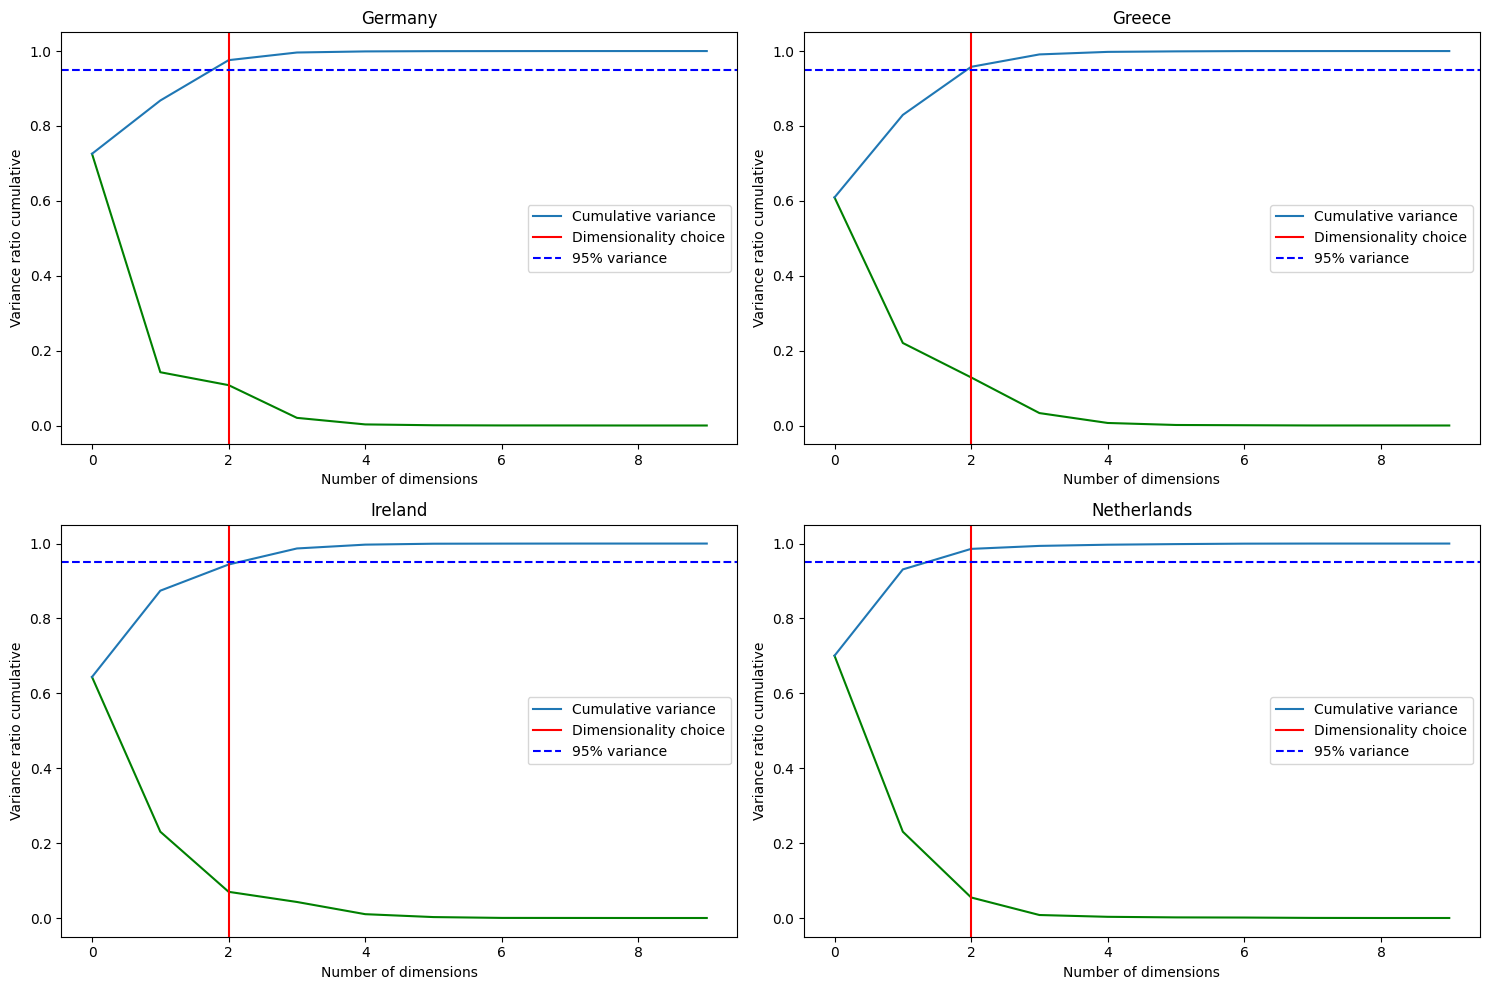

In [69]:
countries = ESG_denoised['country'].unique()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for index, country in enumerate(countries):
    country_data = ESG_denoised[ESG_denoised['country'] == country]
    country_data_scaled = country_data.drop(columns=['country', 'date', 'gdppc'])
    
    scaler_standard = StandardScaler()
    country_data_scaled = scaler_standard.fit_transform(country_data_scaled)
    
    pca = PCA().fit(country_data_scaled)
    
    axes[index].plot(pca.explained_variance_ratio_, color='g') 
    axes[index].plot(pca.explained_variance_ratio_.cumsum(), label='Cumulative variance') 
    axes[index].set_xlabel('Number of dimensions')
    axes[index].set_ylabel('Variance ratio cumulative')
    axes[index].set_title(f'{country}')
    axes[index].axvline(2, color='r', label='Dimensionality choice') 
    axes[index].axhline(0.95, color='b', linestyle= '--', label='95% variance') 
    axes[index].legend()

plt.tight_layout()
plt.show()


In [24]:
# For each country do a separate PCA 
PCA_total = []  
for country in ESG_denoised['country'].unique():
    country_data = ESG_denoised[ESG_denoised['country'] == country]
    country_data_scaled = country_data.drop(columns=['country', 'date', 'gdppc'])
    
    scaler_standard = StandardScaler()
    country_data_scaled = scaler_standard.fit_transform(country_data_scaled)

    pca = PCA(n_components=2).fit(country_data_scaled)
    country_pca = pca.transform(country_data_scaled)
    
    PCA_percountry = pd.DataFrame(data=country_pca, columns=['pca1','pca2'])
    PCA_percountry['country'] = country
    PCA_percountry['date'] = country_data['date'].values
    PCA_percountry['gdppc'] = country_data['gdppc'].values
    
    PCA_total.append(PCA_percountry)

PCA_columns=['pca1','pca2']
# Merge the PCA's per country in a dataframe
ESG_pca_df = pd.concat(PCA_total, ignore_index=True)
ESG_pca_df.head()

pca1      pca2  country  date         gdppc
0  5.996098  2.369383  Germany  2020  47941.801415
1  4.537602  1.321426  Germany  2019  46800.350744
2  3.079106  0.273468  Germany  2018  45658.900073
3  1.735894 -0.845695  Germany  2017  44524.986290
4  1.304738 -0.998890  Germany  2016  44771.022934

## Machine Learning Models
### Prepare the data for the Machine Learning models

In [25]:
# Results Machine Learning methods Dataframe
df_ML_results = pd.DataFrame()
df_ML_results['Random Forest - MAE'] = np.nan
df_ML_results['Random Forest - RMSE'] = np.nan
df_ML_results['Linear Regression - MAE'] = np.nan
df_ML_results['Linear Regression - RMSE'] = np.nan
df_ML_results['Neural Network - MAE'] = np.nan
df_ML_results['Neural Network - RMSE'] = np.nan

In [26]:
# function to get the results fastly per country 
def results(y_test, y_predict, method, country): 
    MSE = mean_squared_error(y_test, y_predict) 
    RMSE = math.sqrt(MSE)
    R2 = r2_score(y_test, y_predict)
    MAE = mean_absolute_error(y_test, y_predict)
    return print(f'{method}, {country}: the RMSE is {RMSE}, and R2 is {R2}, and MAE is {MAE}')

In [27]:
def get_metric(y_test, y_predict): 
    MSE = mean_squared_error(y_test, y_predict) 
    RMSE = math.sqrt(MSE)
    R2 = r2_score(y_test, y_predict)
    MAE = mean_absolute_error(y_test, y_predict)
    return MSE, RMSE, R2, MAE

### K fold cross validation

In [28]:
def cross_validate_train_test_sets(data, pca_columns, K_subset): 
    dates = sorted(data['date'].unique())
    nr_dates = len(dates)
    subset_size = int(nr_dates / K_subset)
    shuffle_data = []

    for shuffle in range(K_subset):
        start = shuffle * subset_size
        test_dates = dates[shuffle * subset_size:start + subset_size]
        train_dates = [date for date in dates if date not in test_dates]
        
        X_train = data[data['date'].isin(train_dates)][pca_columns]
        y_train = data[data['date'].isin(train_dates)]['gdppc']
        X_test = data[data['date'].isin(test_dates)][pca_columns]
        y_test = data[data['date'].isin(test_dates)]['gdppc']

        shuffle_data.append((X_train, y_train, X_test, y_test)) 

    return shuffle_data


## Random Forest

In [29]:
def RandomForest_per__country(country, ESG_pca_df, PCA_columns):
    predict_RF = []
    real_RF = []
    RMSE_RF = []
    MAE_RF = []
    K_subset = 5
    shuffled = cross_validate_train_test_sets(ESG_pca_df[ESG_pca_df['country'] == country], PCA_columns, K_subset)

    for shuffle in range(K_subset):   
        X_train, y_train, X_test, y_test = shuffled[shuffle]

        random_forest_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
        random_forest_model.fit(X_train, y_train)
        y_predict_rf = random_forest_model.predict(X_test) 
        predict_RF.append(y_predict_rf)
        real_RF.append(y_test) 

        results(y_test, y_predict_rf, 'Random Forest', country) 
        MSE, RMSE, R2, MAE = get_metric(y_test, y_predict_rf)
        RMSE_RF.append(RMSE)
        MAE_RF.append(MAE)

    RMSE_mean_RF = np.mean(RMSE_RF)
    MAE_mean_RF = np.mean(MAE_RF) 
    
    return predict_RF, real_RF, RMSE_mean_RF, MAE_mean_RF

Alpha Lambda plot for the visualization of the predicted gdppc with an alpha of 20%

Random Forest, Germany: the RMSE is 13314.498592336136, and R2 is -15.691519632158194, and MAE is 12595.449194455134
Random Forest, Germany: the RMSE is 2108.6546367928236, and R2 is 0.09703247867044673, and MAE is 1786.4291720795627
Random Forest, Germany: the RMSE is 1287.6783605977128, and R2 is -2.485306137441391, and MAE is 1167.9867141042596
Random Forest, Germany: the RMSE is 1233.5896067336546, and R2 is -11.439662286423657, and MAE is 1086.2336888384416
Random Forest, Germany: the RMSE is 7748.828274313614, and R2 is -36.0142447829047, and MAE is 6602.615411657771
Random Forest, Greece: the RMSE is 8679.777593176635, and R2 is -7.3515563538537165, and MAE is 8118.586874656395
Random Forest, Greece: the RMSE is 7519.296702221644, and R2 is -13.852141862289173, and MAE is 7274.744734564099
Random Forest, Greece: the RMSE is 1513.5252185735171, and R2 is 0.39568092802580146, and MAE is 1296.2887593035002
Random Forest, Greece: the RMSE is 1150.2455495617432, and R2 is -0.36857794

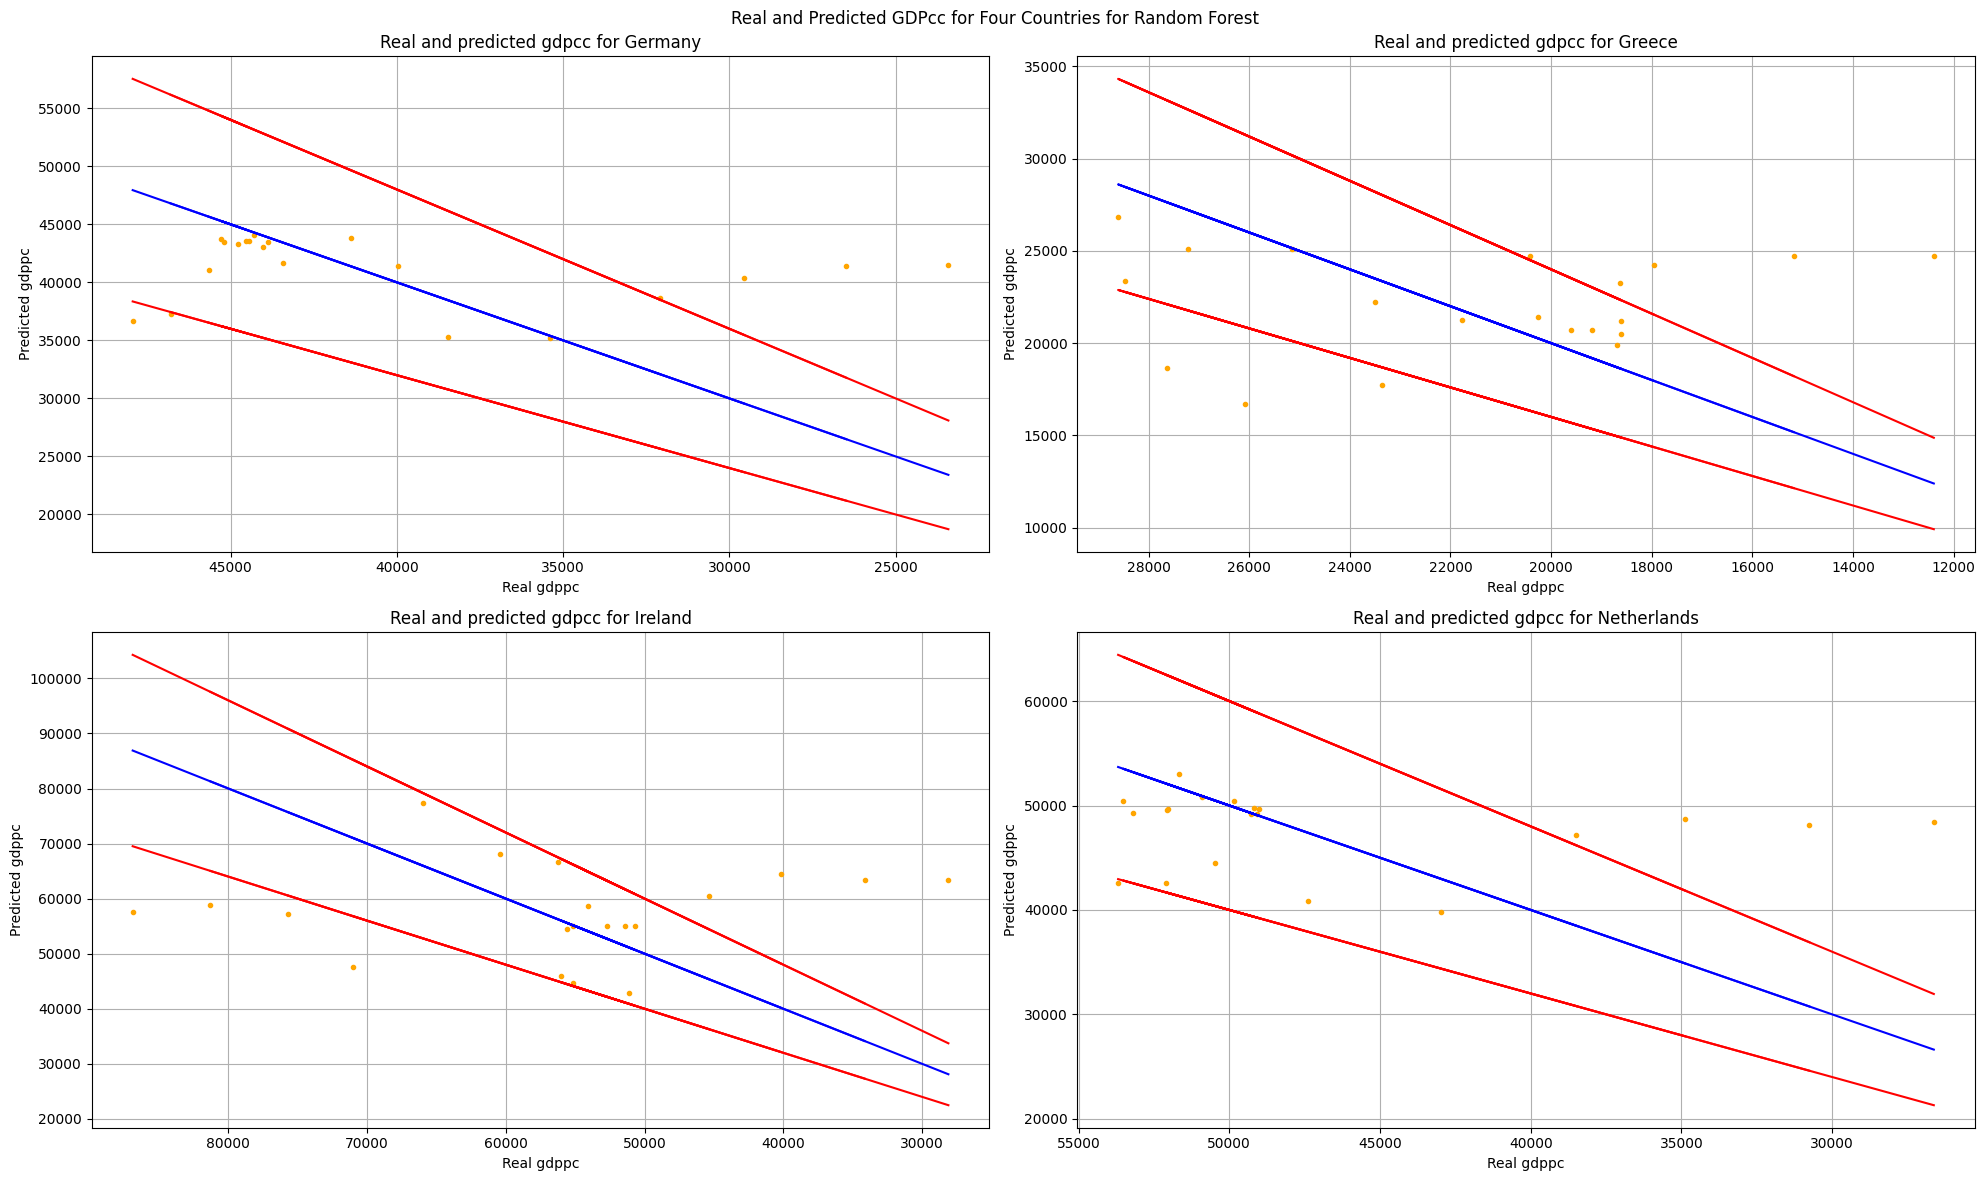

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Real and Predicted GDPcc for Four Countries for Random Forest')
subplot_index = [(0,0), (0,1), (1,0), (1,1)]
RMSE_mean_RF_all = []
MAE_mean_RF_all = []
for index, country in enumerate(ESG_denoised['country'].unique()):
    predict_RF, real_RF, RMSE_mean_RF, MAE_mean_RF = RandomForest_per__country(country, ESG_pca_df, PCA_columns)
    RMSE_mean_RF_all.append(RMSE_mean_RF)
    MAE_mean_RF_all.append(MAE_mean_RF)

    alpha = 0.2
    real_RF_np = np.array(real_RF)
    upper_bound = real_RF_np * (1 + alpha)
    lower_bound = real_RF_np * (1 - alpha)

    ax = axs[subplot_index[index]]  # get the correct axis
    ax.plot(real_RF, predict_RF, '.', color='orange')
    ax.plot(real_RF, real_RF, 'b-')
    ax.plot(real_RF, upper_bound, 'r-')
    ax.plot(real_RF, lower_bound, 'r-')
    ax.invert_xaxis()
    ax.set_title(f'Real and predicted gdpcc for {country}')
    ax.set_xlabel('Real gdppc')
    ax.set_ylabel('Predicted gdppc')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [31]:
df_ML_results['Random Forest - MAE'] = MAE_mean_RF_all
df_ML_results['Random Forest - RMSE'] = RMSE_mean_RF_all

## Linear Regression

In [32]:
def LinearRegression_per__country(country, ESG_pca_df, PCA_columns):
    predict_LR = []
    real_LR = []
    RMSE_LR = []
    MAE_LR = []
    K_subset = 5
    shuffled = cross_validate_train_test_sets(ESG_pca_df[ESG_pca_df['country'] == country], PCA_columns, K_subset)

    for shuffle in range(K_subset):   
        X_train, y_train, X_test, y_test = shuffled[shuffle]

        linear_regression_model = LinearRegression()
        linear_regression_model.fit(X_train, y_train)
        y_predict_LR = linear_regression_model.predict(X_test) 
        predict_LR.append(y_predict_LR)
        real_LR.append(y_test) 

        results(y_test, y_predict_LR, 'Linear Regression', country) 
        MSE, RMSE, R2, MAE = get_metric(y_test, y_predict_LR)

        RMSE_LR.append(RMSE)
        MAE_LR.append(MAE)

    RMSE_mean_LR = np.mean(RMSE_LR)
    MAE_mean_LR = np.mean(MAE_LR) 
    
    return predict_LR, real_LR, RMSE_mean_LR, MAE_mean_LR

Linear Regression, Germany: the RMSE is 5048.403637299863, and R2 is -1.3996858317717829, and MAE is 4896.758134110606
Linear Regression, Germany: the RMSE is 1607.9527759283812, and R2 is 0.4749413728967571, and MAE is 1347.6894755672874
Linear Regression, Germany: the RMSE is 1659.5484686580444, and R2 is -4.789032903126298, and MAE is 1425.7330992876396
Linear Regression, Germany: the RMSE is 988.7407117250442, and R2 is -6.991568388663693, and MAE is 841.0491600569603
Linear Regression, Germany: the RMSE is 2348.298559626235, and R2 is -2.3994091840847704, and MAE is 2339.376404980372
Linear Regression, Greece: the RMSE is 10796.079253657601, and R2 is -11.920590124728898, and MAE is 10367.086707814964
Linear Regression, Greece: the RMSE is 7211.397630180299, and R2 is -12.66071814048566, and MAE is 7156.490070901154
Linear Regression, Greece: the RMSE is 2637.921272991708, and R2 is -0.8357377450600636, and MAE is 2211.8507929893385
Linear Regression, Greece: the RMSE is 2598.4901

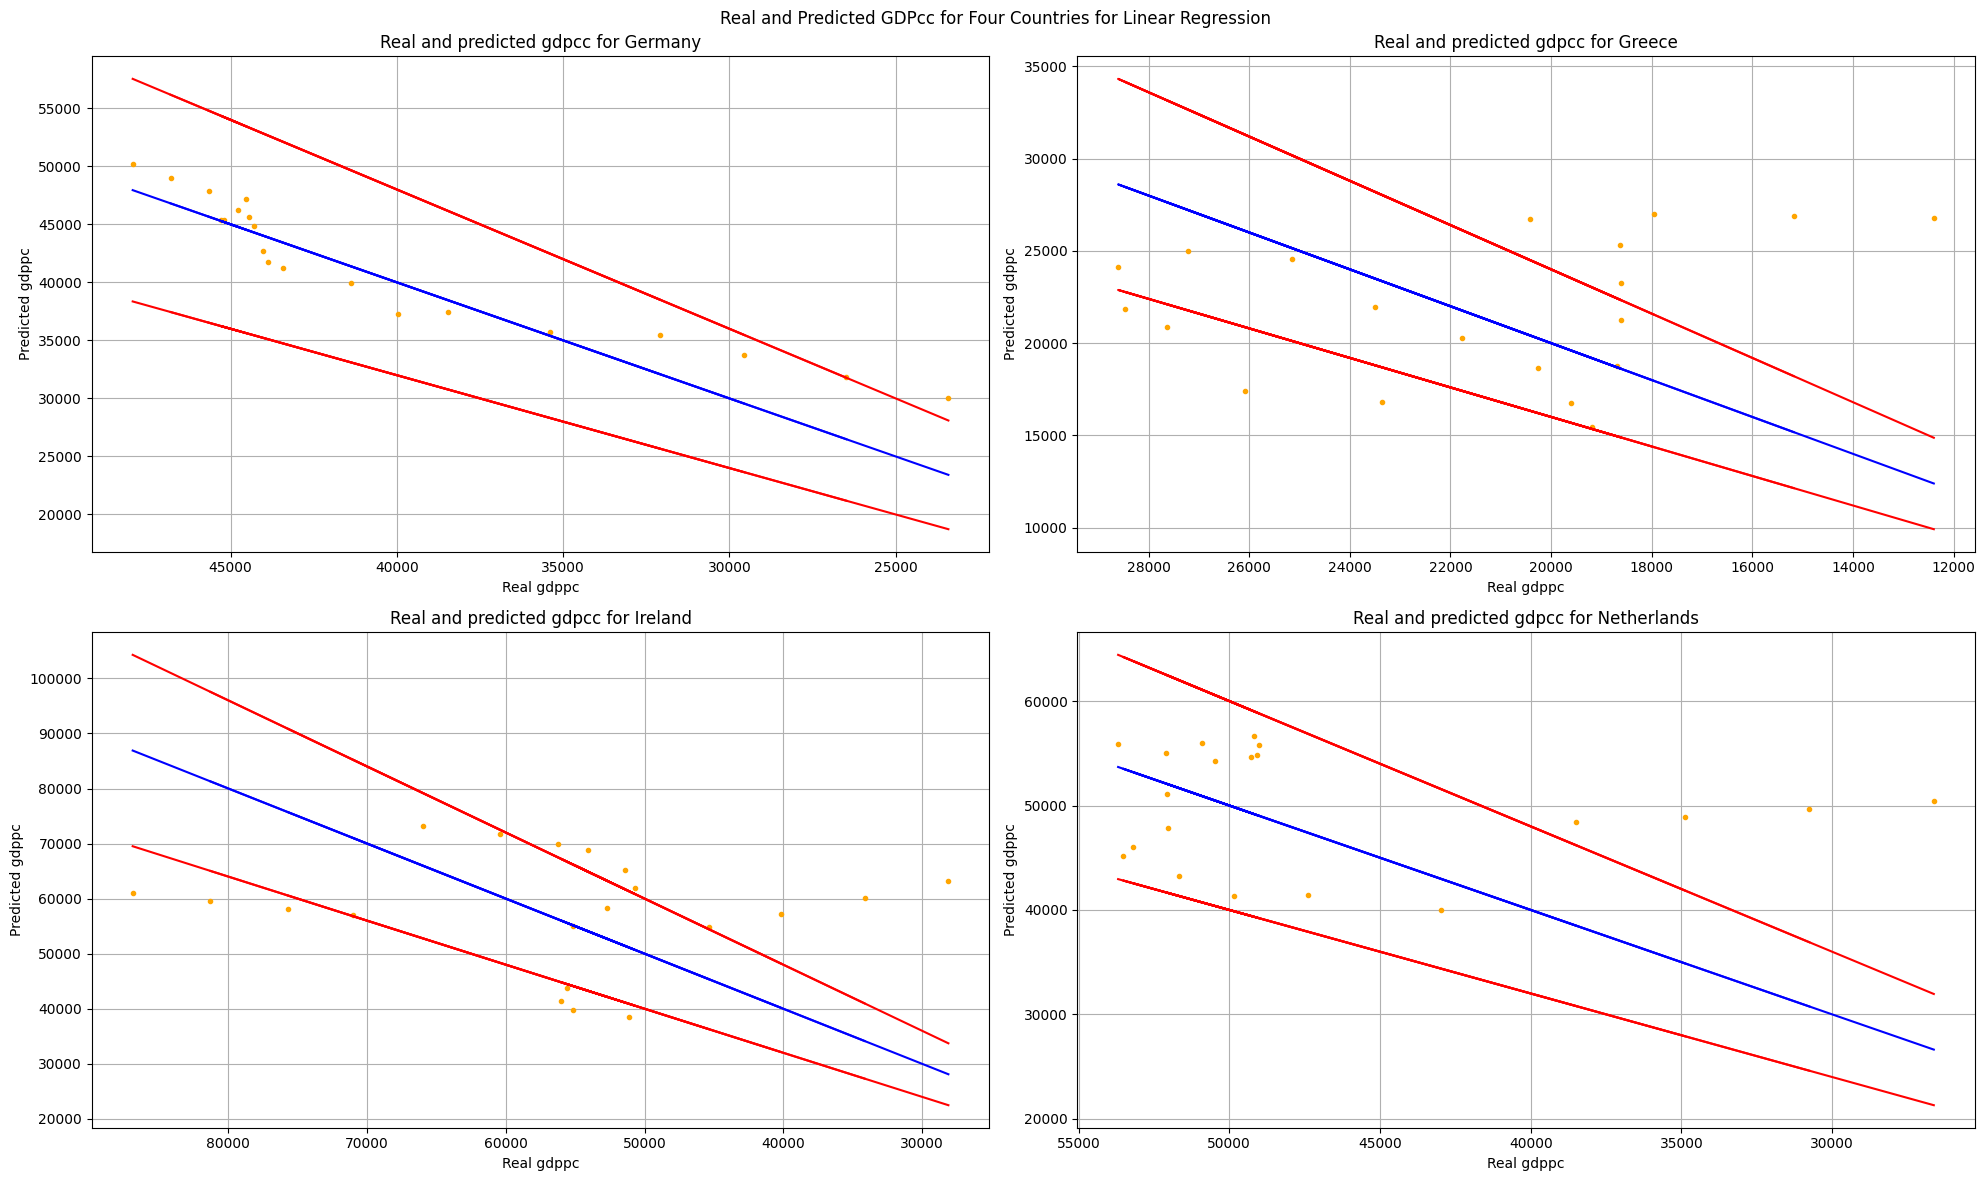

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Real and Predicted GDPcc for Four Countries for Linear Regression')
subplot_index = [(0,0), (0,1), (1,0), (1,1)]
RMSE_mean_LR_all = []
MAE_mean_LR_all = []
for index, country in enumerate(ESG_denoised['country'].unique()):
    predict_LR, real_LR, RMSE_mean_LR, MAE_mean_LR = LinearRegression_per__country(country, ESG_pca_df, PCA_columns)
    RMSE_mean_LR_all.append(RMSE_mean_LR)
    MAE_mean_LR_all.append(MAE_mean_LR)

    alpha = 0.2
    real_LR_np = np.array(real_LR)
    upper_bound = real_LR_np * (1 + alpha)
    lower_bound = real_LR_np * (1 - alpha)

    ax = axs[subplot_index[index]]  # get the correct axis
    ax.plot(real_LR, predict_LR, '.', color='orange')
    ax.plot(real_LR, real_LR, 'b-')
    ax.plot(real_LR, upper_bound, 'r-')
    ax.plot(real_LR, lower_bound, 'r-')
    ax.invert_xaxis()
    ax.set_title(f'Real and predicted gdpcc for {country}')
    ax.set_xlabel('Real gdppc')
    ax.set_ylabel('Predicted gdppc')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [34]:
df_ML_results['Linear Regression - MAE'] = MAE_mean_LR_all
df_ML_results['Linear Regression - RMSE'] = RMSE_mean_LR_all

## Neural Network

In [65]:
def MLP_per__country(country, ESG_pca_df, PCA_columns):
    predict_MLP = []
    real_MLP = []
    RMSE_MLP = []
    MAE_MLP = []
    K_subset = 5
    shuffled = cross_validate_train_test_sets(ESG_pca_df[ESG_pca_df['country'] == country], PCA_columns, K_subset)

    for shuffle in range(K_subset):   
        X_train, y_train, X_test, y_test = shuffled[shuffle]

        MLP_model = MLPRegressor(hidden_layer_sizes=(64, 128, 64), activation='relu', solver='adam', max_iter= 5000)
        MLP_model.fit(X_train, y_train)
        y_predict_MLP = MLP_model.predict(X_test) 
        predict_MLP.append(y_predict_MLP)
        real_MLP.append(y_test) 

        results(y_test, y_predict_MLP, 'MLP neural network', country) 
        MSE, RMSE, R2, MAE = get_metric(y_test, y_predict_MLP)
        RMSE_MLP.append(RMSE)
        MAE_MLP.append(MAE)

    RMSE_mean_MLP = np.mean(RMSE_MLP)
    MAE_mean_MLP = np.mean(MAE_MLP)

    return predict_MLP, real_MLP, RMSE_mean_MLP, MAE_mean_MLP

MLP neural network, Germany: the RMSE is 23114.428645951077, and R2 is -49.30516421213147, and MAE is 21147.95282080957
MLP neural network, Germany: the RMSE is 817.9603936327721, and R2 is 0.8641293135336946, and MAE is 791.1671854736942
MLP neural network, Germany: the RMSE is 1277.5588122298582, and R2 is -2.430741058063095, and MAE is 1130.153248534989
MLP neural network, Germany: the RMSE is 376.0812297321625, and R2 is -0.15619344644090005, and MAE is 347.42487982086277
MLP neural network, Germany: the RMSE is 9131.500929154481, and R2 is -50.402134685417096, and MAE is 7209.9841037459555
MLP neural network, Greece: the RMSE is 10001.764458104828, and R2 is -10.089283003871357, and MAE is 9529.952742798892
MLP neural network, Greece: the RMSE is 5721.445981888241, and R2 is -7.598966340462734, and MAE is 5453.739865763462
MLP neural network, Greece: the RMSE is 11362.925008852322, and R2 is -33.06177362590956, and MAE is 9535.97313187882
MLP neural network, Greece: the RMSE is 10

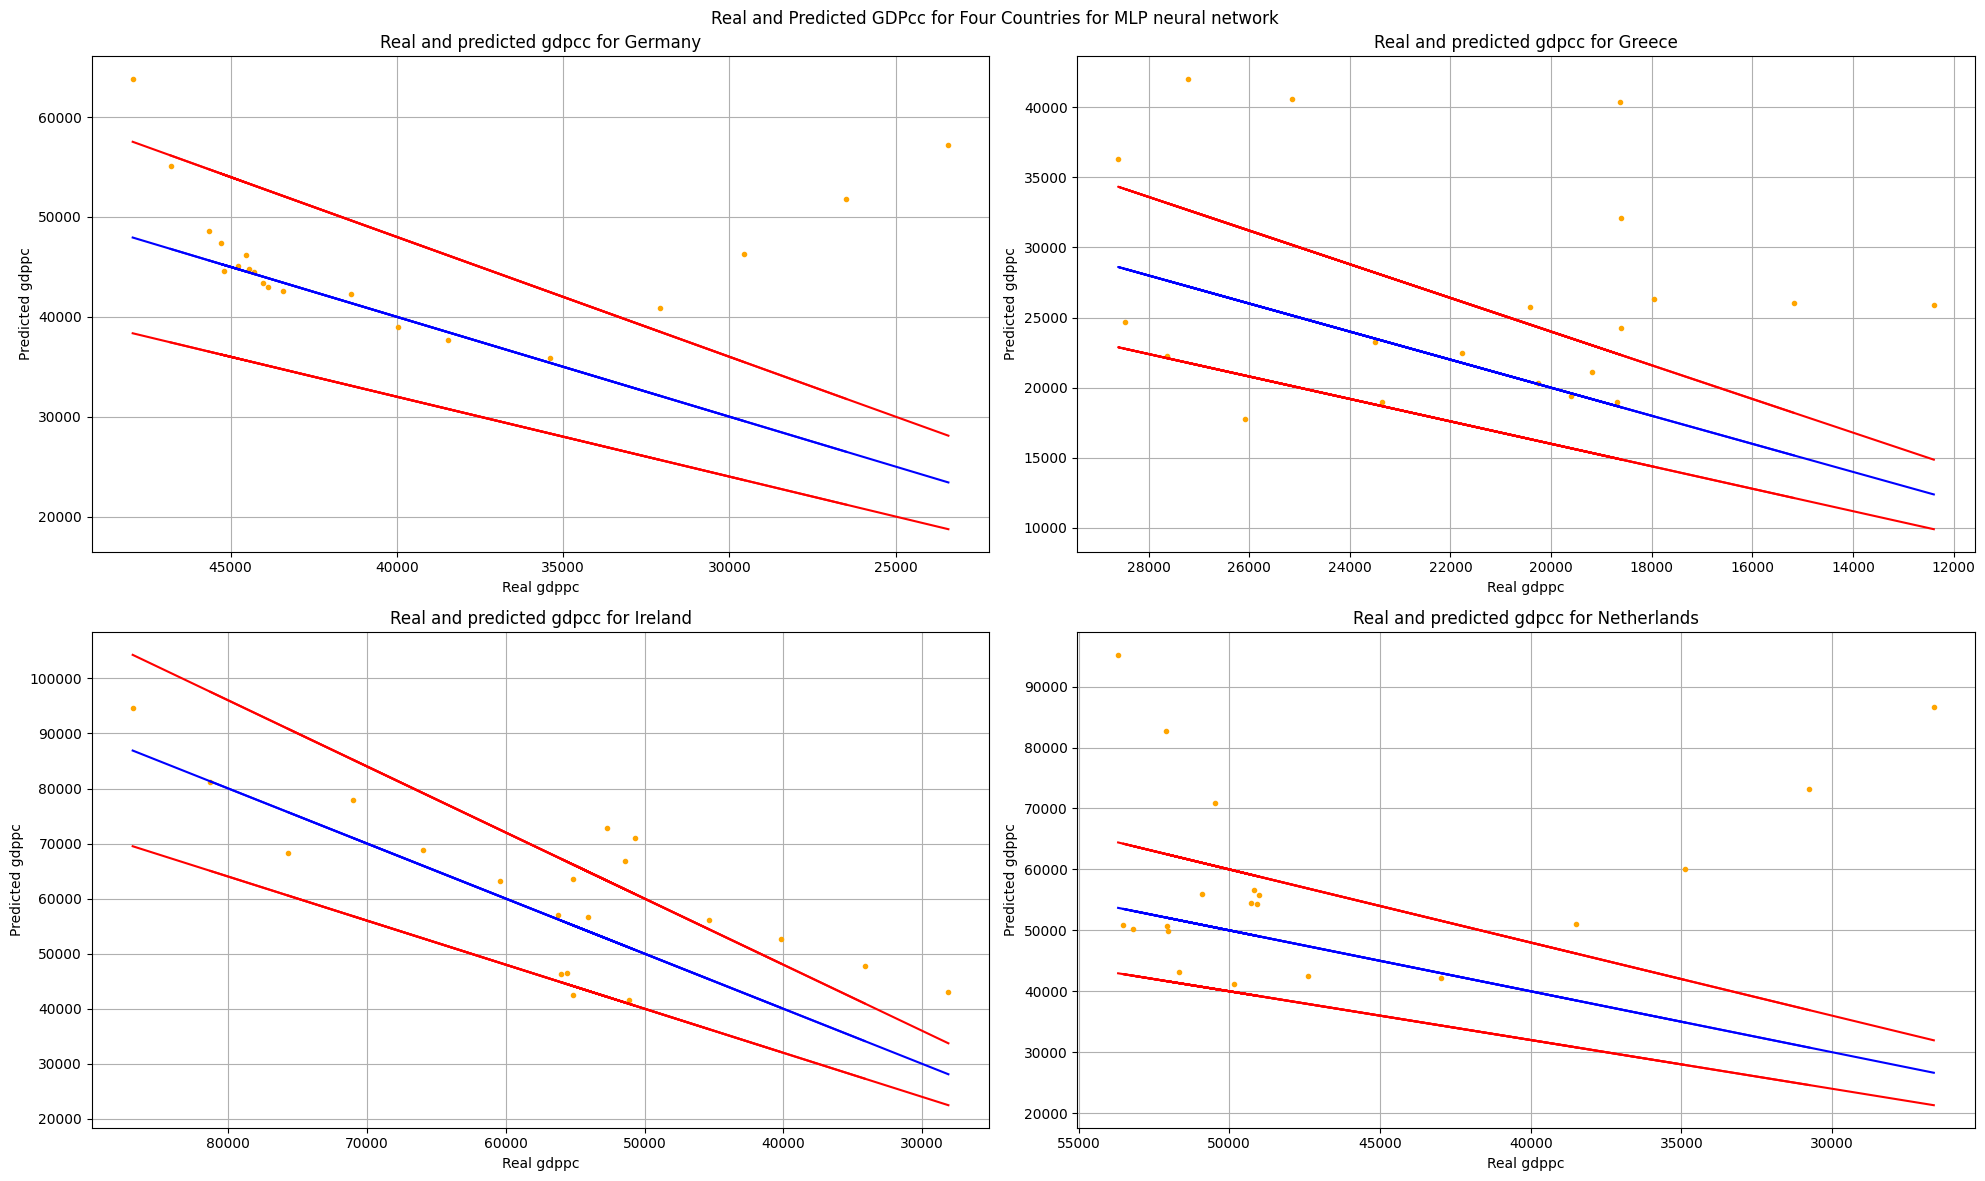

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Real and Predicted GDPcc for Four Countries for MLP neural network')
subplot_index = [(0,0), (0,1), (1,0), (1,1)]
RMSE_mean_MLP_all = []
MAE_mean_MLP_all = []
for index, country in enumerate(ESG_denoised['country'].unique()):
    predict_MLP, real_MLP, RMSE_mean_MLP, MAE_mean_MLP = MLP_per__country(country, ESG_pca_df, PCA_columns)
    RMSE_mean_MLP_all.append(RMSE_mean_MLP)
    MAE_mean_MLP_all.append(MAE_mean_MLP) 
    
    alpha = 0.2
    real_MLP_np = np.array(real_MLP)
    upper_bound = real_MLP_np * (1 + alpha)
    lower_bound = real_MLP_np * (1 - alpha)

    ax = axs[subplot_index[index]]  # get the correct axis
    ax.plot(real_MLP, predict_MLP, '.', color='orange')
    ax.plot(real_MLP, real_MLP, 'b-')
    ax.plot(real_MLP, upper_bound, 'r-')
    ax.plot(real_MLP, lower_bound, 'r-')
    ax.invert_xaxis()
    ax.set_title(f'Real and predicted gdpcc for {country}')
    ax.set_xlabel('Real gdppc')
    ax.set_ylabel('Predicted gdppc')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [67]:
df_ML_results['Neural Network - MAE'] = MAE_mean_MLP_all
df_ML_results['Neural Network - RMSE'] = RMSE_mean_MLP_all

## Results

In [68]:
countries = ['Germany', 'Greece', 'Ireland', 'Netherlands']
df_ML_results.index = countries
df_ML_results

Random Forest - MAE  Random Forest - RMSE  \
Germany              4647.742836           5138.649894   
Greece               4069.223739           4345.942181   
Ireland             13592.764942          14208.723570   
Netherlands          5664.456560           6245.620943   

             Linear Regression - MAE  Linear Regression - RMSE  \
Germany                  2170.121255               2330.588831   
Greece                   5137.058491               5506.549960   
Ireland                 14942.138127              15862.464352   
Netherlands              7626.974725               8069.692305   

             Neural Network - MAE  Neural Network - RMSE  
Germany               6125.336448            6943.506002  
Greece                7107.043376            8244.495484  
Ireland               9406.597433            9780.913696  
Netherlands          14714.708361           16462.219989